# Deep Learning image search

**Image search engines:**
Generally speaking, search engine usually takes a query and returns results. Image search engines takes an input image as an image query, then the image search engine finds the "similar" images within its indexed database and returns them as the search result. 

**How to measure similarity between two images?**   
- 1- **Pixel space**: One simple way is to measure the euclidean distance between the two images in the pixel space. Accordingly, if two images have common or near values for the corresponding pixels, are then considered "similar". This could work some times, however a dolphin and air plane images with blue backgrounds will be considered similar from pixels point of view, and we do not want that!

- 2- **Feature space**: Another approach is to use the feature space instead of pixel space when computing the euclidean distance between the two images. In other words, project the images into a space where images with similar features are close to each others. In this space dolphins and airplanes are separated despite pixel level similarity.      

**How to get features from images?**  
Now the question is, how to project arbitrary image into a space where similar images based on their complex content are grouped together? Well, the answer is easy! Just use a pre-trained generic network such as InceptionV3 trained on the well known ImageNet Large Scale Visual Recognition Challenge (ILSVRC). The network is trained to classify an input image into one of 1000 different classes. Accordingly, if we feed the network with an arbitrary images, and before the output, we can get a strong feature vector that summarizes the content of the input images. that's it.           

For the image search engine, we are going to use the feature vector generated by the a pre- trained network (InceptionV3 for instance), instead of the naive pixel wise approach.         

**Dataset:**   
In the following examples we used the Caltech 101 dataset. For simplicity, only 9 classes are used: 

`['airplanes', 'Motorbikes', 'Faces', 'Faces_easy', 'Leopards', 'car_side', 'grand_piano', 'brain', 'butterfly']`




**Implementation Steps:**   
- Download the data and convert it into X (images) and y (labels)  
- Randomize the data and select a subset of the data as the dataset on which we want to conduct the search
- Load the InceptionV3 network with weights and without the top part to get the high level features.
- Compute the feature for all images in the dataset
- For a query image: Compute its feature vector. Loop and find the euclidean distance between the query image features and the dataset features. Return the nearest results.       

Note: if the dataset is very large, more optimized methods can be used to find the nearest candidates to the query image, such as  KDTree and BallTree. 


In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [2]:
# model = VGG16(weights='imagenet', include_top=False)
model = InceptionV3(weights='imagenet', include_top=False)
model.summary()

87910968/87910968 [==============================] - 18s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activati

In [3]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

# Caltech 101

Link to dataset: https://www.kaggle.com/datasets/imbikramsaha/caltech-101/

In [4]:
from urllib.request import urlretrieve
import os
import tarfile
import cv2
import pprint
import operator

In [7]:
data_directory = "../data"
categories = os.listdir(data_directory + "/101_ObjectCategories/")
object_images_count_dict = {}
for category in categories:
    object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
print(object_images_count_dict)

[('airplanes', 800), ('Motorbikes', 798), ('BACKGROUND_Google', 468), ('Faces', 435), ('Faces_easy', 435), ('watch', 239), ('Leopards', 200), ('bonsai', 128), ('car_side', 123), ('ketch', 114), ('chandelier', 107), ('hawksbill', 100), ('grand_piano', 99), ('brain', 98), ('butterfly', 91), ('helicopter', 88), ('menorah', 87), ('kangaroo', 86), ('starfish', 86), ('trilobite', 86), ('buddha', 85), ('ewer', 85), ('sunflower', 85), ('scorpion', 84), ('revolver', 82), ('laptop', 81), ('ibis', 80), ('llama', 78), ('minaret', 76), ('electric_guitar', 75), ('umbrella', 75), ('crab', 73), ('crayfish', 70), ('cougar_face', 69), ('dragonfly', 68), ('dalmatian', 67), ('ferry', 67), ('flamingo', 67), ('lotus', 66), ('dolphin', 65), ('elephant', 64), ('euphonium', 64), ('joshua_tree', 64), ('soccer_ball', 64), ('stop_sign', 64), ('schooner', 63), ('chair', 62), ('lamp', 61), ('yin_yang', 60), ('cellphone', 59), ('rhino', 59), ('stegosaurus', 59), ('wheelchair', 59), ('cup', 57), ('pyramid', 57), ('se

In [8]:
len(object_images_count_dict)

102

In [9]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data not found!")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # correct colors
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [10]:
i = 0
X = np.ndarray((10000, 200, 300, 3), dtype=np.uint8)
Y = []

selected_cls = ['airplanes', 'Motorbikes', 'Faces', 'Faces_easy', 'Leopards', 'car_side', 'grand_piano', 'brain', 'butterfly']

for category,_ in object_images_count_dict:
    if category in selected_cls:
      for image in get_images(category, data_directory):
          if not image.endswith('.jpg'):
              continue
          X[i] = read_image(image)
          Y.insert(i,category) 
          i += 1
      print(str(i+1) + "  " + category)


X = X[:i]
print("Done")


801  airplanes
1599  Motorbikes
2034  Faces
2469  Faces_easy
2669  Leopards
2792  car_side
2891  grand_piano
2989  brain
3080  butterfly
Done


In [11]:
X.shape

(3079, 200, 300, 3)

In [12]:
Y[0]

'airplanes'

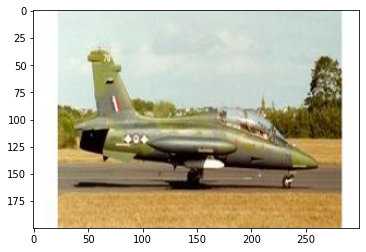

In [13]:
plt.imshow(X[0])

In [14]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([4, 4, 4, ..., 6, 6, 6], dtype=int64)

In [15]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [16]:
label_encoder.inverse_transform([np.argmax(Y_one_hot[0])])

array(['airplanes'], dtype='<U11')

In [17]:
# randomize and select sample data
x_train, x_test, y_train, y_test = train_test_split(X, Y_one_hot, test_size=0.3, random_state=42)

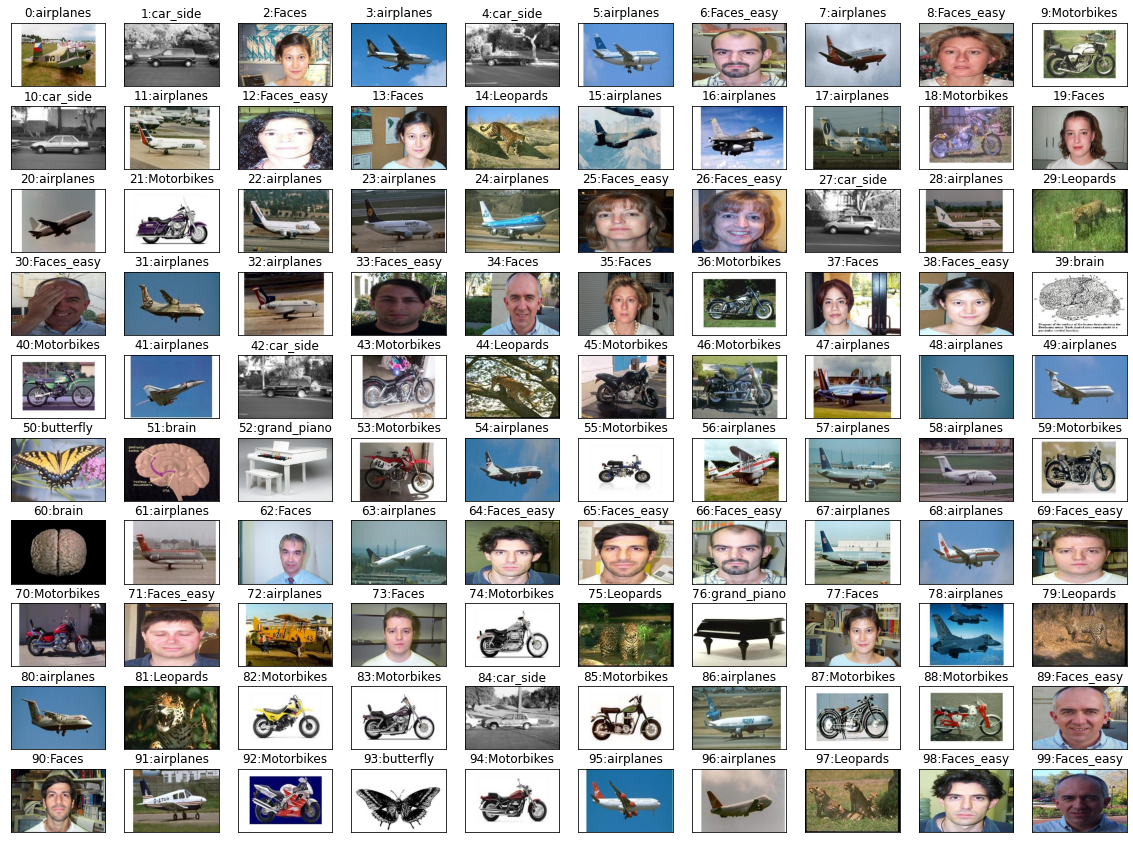

In [18]:
fig=plt.figure(figsize=(20, 15))
columns = 10
rows = 10
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[i])
    t = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
    plt.title(str(i) +":"+ t)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
for i in range(len(selected_cls)):
  print(i , label_encoder.inverse_transform([i])[0])

0 Faces
1 Faces_easy
2 Leopards
3 Motorbikes
4 airplanes
5 brain
6 butterfly
7 car_side
8 grand_piano


In [20]:
data_set = preprocess_input(x_test)

In [21]:
feats = model.predict(data_set)
feats = np.squeeze(feats)
print(feats.shape)

29/29 [==============================] - 72s 2s/step
(924, 4, 8, 2048)


1/1 [==============================] - 0s 130ms/step


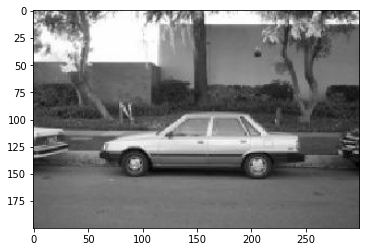

In [22]:
Q_id = 10
Query_image = x_test[Q_id]
plt.imshow(Query_image)
Query_image = preprocess_input(Query_image)
Query_feats = model.predict(np.expand_dims(Query_image, axis=0))
Query_feats = Query_feats.squeeze()

In [23]:
# Euclidean distance
results = []
for i in range(feats.shape[0]):
  d = np.linalg.norm(feats[i].flatten() - Query_feats.flatten())
  results.append((d, i))

results = sorted(results)

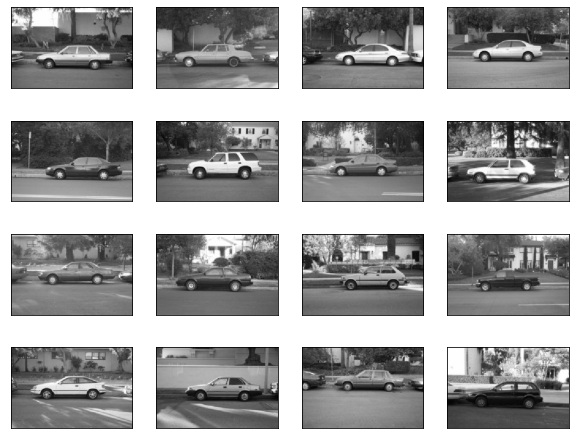

In [24]:
fig=plt.figure(figsize=(10, 8))
columns = 4
rows = 4
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[results[i][1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
# Euclidean distance
results = []
for i in range(x_test.shape[0]):
  d = np.linalg.norm(x_test[i].flatten() - x_test[Q_id].flatten())
  results.append((d, i))

results = sorted(results)

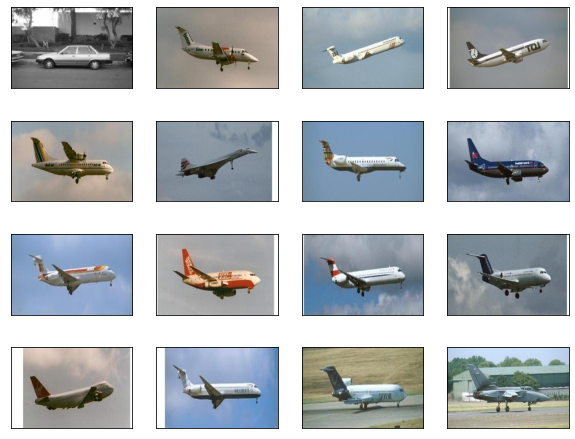

In [26]:
fig=plt.figure(figsize=(10, 8))
columns = 4
rows = 4
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[results[i][1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
# http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html
def plot_dataset(X, y, X_embedded, min_dist=10.0):
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(frameon=False)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0)
    
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)

    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = np.array([[15., 15.]])
        indices = np.arange(X_embedded.shape[0])
        np.random.shuffle(indices)
        for i in indices[:5000]:
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            res = cv2.resize(X[i], dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(res), X_embedded[i])
            ax.add_artist(imagebox)

In [28]:
n_tsne = 300

In [29]:
tsne_feats = np.reshape(feats, (feats.shape[0], feats.shape[1]*feats.shape[2]*feats.shape[3]))[:n_tsne]
tsne_f = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(tsne_feats)
print(tsne_f.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.021s...
[t-SNE] Computed neighbors for 300 samples in 2.071s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 63.439194
[t-SNE] Computed conditional probabilities in 0.029s
[t-SNE] Iteration 50: error = 55.7935486, gradient norm = 0.1866431 (50 iterations in 0.063s)
[t-SNE] Iteration 100: error = 56.4483223, gradient norm = 0.1068665 (50 iterations in 0.071s)
[t-SNE] Iteration 150: error = 55.7639046, gradient norm = 0.1954278 (50 iterations in 0.083s)
[t-SNE] Iteration 200: error = 56.1116867, gradient norm = 0.1719398 (50 iterations in 0.189s)
[t-SNE] Iteration 250: error = 57.1815872, gradient norm = 0.1678544 (50 iterations in 0.071s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.181587
[t-SNE] Iteration 300: error = 0.4755630, gradient norm = 0.0107083 (50 iterations in 0.051s)
[t-SNE] Iteration 350: error = 0.4477746, gradient norm = 0.0027051 

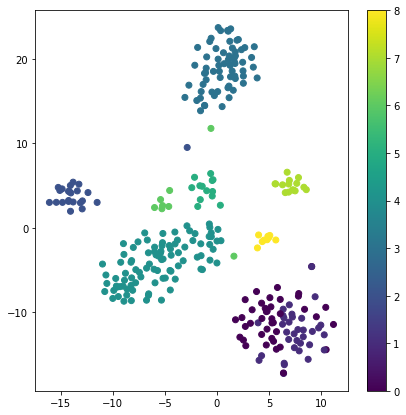

In [30]:
c = np.argmax(y_test[:n_tsne], axis=1)

plt.figure(figsize=(7, 7))
plt.scatter(tsne_f[:, 0], tsne_f[:, 1], c=c)

plt.colorbar()
plt.show()

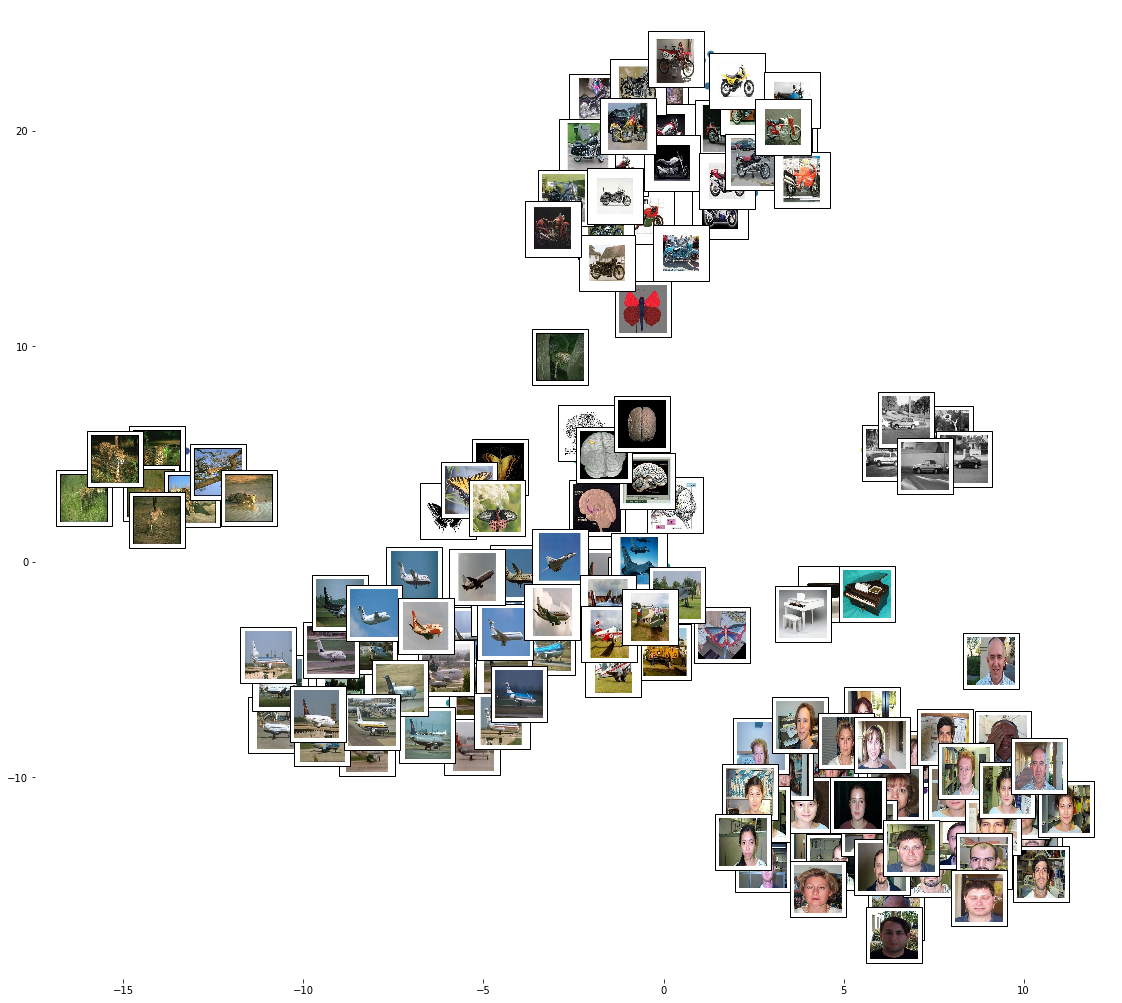

In [31]:
plot_dataset(x_test[:n_tsne], c[:n_tsne], tsne_f[:n_tsne], min_dist=1.0)

In [32]:
tsne_pix = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3]))[:n_tsne]
tsne_p = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(tsne_pix)   
print(tsne_p.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.050s...
[t-SNE] Computed neighbors for 300 samples in 7.293s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 11335.210623
[t-SNE] Computed conditional probabilities in 0.031s
[t-SNE] Iteration 50: error = 58.2894745, gradient norm = 0.2364636 (50 iterations in 0.082s)
[t-SNE] Iteration 100: error = 57.7895012, gradient norm = 0.1858456 (50 iterations in 0.060s)
[t-SNE] Iteration 150: error = 59.4584045, gradient norm = 0.1154279 (50 iterations in 0.073s)
[t-SNE] Iteration 200: error = 57.6412048, gradient norm = 0.6705661 (50 iterations in 0.050s)
[t-SNE] Iteration 250: error = 58.2899284, gradient norm = 0.2473725 (50 iterations in 0.094s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.289928
[t-SNE] Iteration 300: error = 0.6698307, gradient norm = 0.0054275 (50 iterations in 0.073s)
[t-SNE] Iteration 350: error = 0.6496737, gradient norm = 0.00203

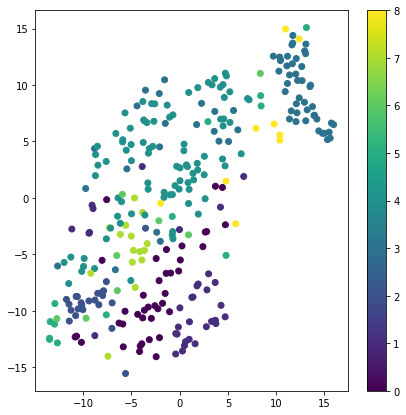

In [33]:
c = np.argmax(y_test[:n_tsne], axis=1)

plt.figure(figsize=(7, 7))
plt.scatter(tsne_p[:, 0], tsne_p[:, 1], c=c)

plt.colorbar()
plt.show()

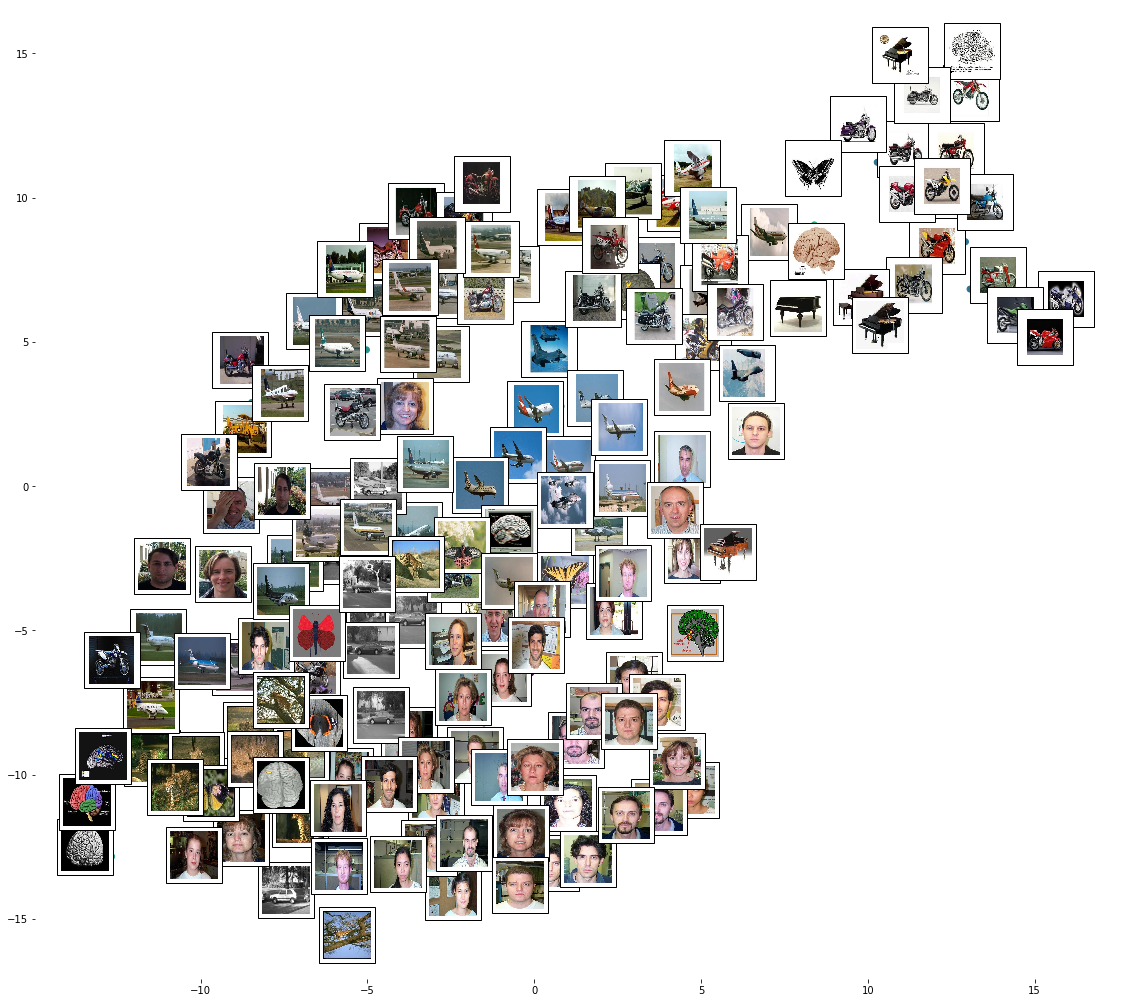

In [34]:
plot_dataset(x_test[:n_tsne], c[:n_tsne], tsne_p[:n_tsne], min_dist=1.0)